# 1.) Import the data from CCLE into a new Google Colab file

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing 

In [ ]:
drive.mount('/content/gdrive/', force_remount = True)


Mounted at /content/gdrive/


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/insurance.csv")

df.loc[df["sex"] == "female","sex"] = 1
df.loc[df["sex"] == "male","sex"] = 0

In [ ]:
df = pd.DataFrame(pd.get_dummies(df))
df.iloc[1]

age                   18.0000
bmi                   33.7700
children               1.0000
charges             1725.5523
sex_0                  1.0000
sex_1                  0.0000
smoker_no              1.0000
smoker_yes             0.0000
region_northeast       0.0000
region_northwest       0.0000
region_southeast       1.0000
region_southwest       0.0000
Name: 1, dtype: float64

,age,bmi,children,charges,sex_0,sex_1,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0,1,0,0
1334,18,31.920,0,2205.98080,0,1,1,0,1,0,0,0
1335,18,36.850,0,1629.83350,0,1,1,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,1,1,0,0,0,0,1


# 2.) Split the data into 80/20, in/out sample

In [ ]:
import numpy as np
df2 = df.drop(columns = ["charges"])
print(df)
data = np.array(df2)
#age, sex, bmi

target = np.array(df.iloc[:,3])
#insurance charges
target

      age     bmi  children      charges  sex_0  sex_1  smoker_no  smoker_yes  \
0      19  27.900         0  16884.92400      0      1          0           1   
1      18  33.770         1   1725.55230      1      0          1           0   
2      28  33.000         3   4449.46200      1      0          1           0   
3      33  22.705         0  21984.47061      1      0          1           0   
4      32  28.880         0   3866.85520      1      0          1           0   
...   ...     ...       ...          ...    ...    ...        ...         ...   
1333   50  30.970         3  10600.54830      1      0          1           0   
1334   18  31.920         0   2205.98080      0      1          1           0   
1335   18  36.850         0   1629.83350      0      1          1           0   
1336   21  25.800         0   2007.94500      0      1          1           0   
1337   61  29.070         0  29141.36030      0      1          0           1   

      region_northeast  reg

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [ ]:
cut = int((len(data) * .8) // 1)

In [ ]:
in_data = data[:cut]
out_data = data[cut:]

in_target = target[:cut]
out_target = target[cut:]

# 3.) Normalize the Data

In [ ]:
scaler = preprocessing.StandardScaler().fit(in_data)
in_data_scale = scaler.transform(in_data)

out_data_scale = scaler.transform(out_data)

# 4.) Get lambda from Lasso cross validation

In [ ]:
#get fit alpha/lambda
from sklearn.linear_model import LassoCV
#a = modCV
modCV = LassoCV().fit(in_data_scale, in_target)
a = modCV.alpha_
a


176.27926602952408

# 5.) Run a lambda regression with that Lambda

In [ ]:
#use Lass
from sklearn.linear_model import Lasso
mod1 = Lasso(alpha = a).fit(in_data_scale, in_target)
mod1.coef_
#mod1.predict(np.array(in_data_scale))

array([ 3.52800434e+03,  1.82630392e+03,  3.57050430e+02, -0.00000000e+00,
        0.00000000e+00, -9.28060537e+03,  1.93118875e-12,  1.84611649e+02,
        0.00000000e+00, -0.00000000e+00, -6.52070860e+01])

# 6.) Visualize the coefficients 

In [ ]:
mod1.coef_

array([ 3.52800434e+03,  1.82630392e+03,  3.57050430e+02, -0.00000000e+00,
        0.00000000e+00, -9.28060537e+03,  1.93118875e-12,  1.84611649e+02,
        0.00000000e+00, -0.00000000e+00, -6.52070860e+01])

<BarContainer object of 11 artists>

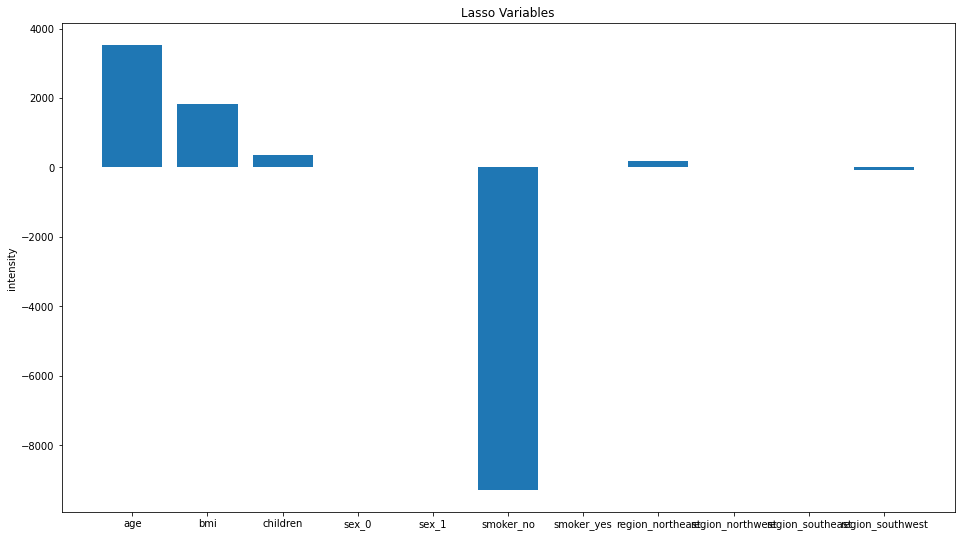

In [ ]:
plt.figure(figsize = (16,9))
plt.ylabel("intensity")
plt.title("Lasso Variables")
plt.bar(df2.columns, mod1.coef_)

# 7.) Interpret the coefficients

Through the Lasso Regression, we find that dummy variables for sex have been nullified. Most of the regional dummies have either been nullified or have an extremely small magnitude. While the dummy smoker_yes has been nullified, the variable smoker_no has a huge effect on the expense of insurance. This means if the individual is a non-smoker, their insurance expense will be much lower than otherwise. 
  Other than smoker_no, age and bmi both have strong positive effects on insurance expense 


# 8.) Compare in and out of sample MSE’s

In [ ]:
train_pred = mod1.predict(in_data_scale)
test_pred = mod1.predict(out_data_scale)

from sklearn import metrics

In [ ]:
#In sample MSE
np.sqrt(metrics.mean_squared_error(in_target,train_pred))

6050.050430015304

In [ ]:
#out of sample MSE
np.sqrt(metrics.mean_squared_error(out_target,test_pred))

6107.787546899505

In [ ]:
#The out of sample MSE slightly larger than the in sample MSE.